In [1]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import TransformerPayne, METALS, Blackbody
import jax.numpy as jnp
%matplotlib inline

from tqdm import tqdm

# TZ Fornacis Binary System Simulation

This notebook demonstrates the simulation of the TZ Fornacis binary star system using the SPICE (Stellar Physics Interactive Computational Environment) framework. TZ Fornacis is a well-studied eclipsing binary system consisting of a G8III primary and an A5V secondary star with an orbital period of approximately 75.6 days. The system parameters are adapted from [Gallenne et al, 2016](https://www.aanda.org/articles/aa/full_html/2016/02/aa26764-15/aa26764-15.html).

In this notebook, we will:
1. Set up the binary system with realistic stellar parameters
2. Calculate the orbital dynamics over time
3. Generate synthetic spectra and light curves for the system

The simulation uses the Transformer Payne model for stellar atmospheres and an icosphere mesh to represent the stellar surfaces.

In [2]:
tp = TransformerPayne.download()
bb = Blackbody()

Since calculating the orbit for a binary requires significant memory allocation, we are performing the calculation in chunks like so:

In [3]:
import astropy.units as u
u.M_jupiter.to(u.solMass)

0.0009545942339693249

In [ ]:
#body1 = IcosphereModel.construct(500, 1., 1., tp.to_parameters(), tp.stellar_parameter_names)
body1 = IcosphereModel.construct(1000, 1., 1., bb.to_parameters(), bb.stellar_parameter_names)
body2 = IcosphereModel.construct(1000, u.R_jupiter.to(u.solRad), u.M_jupiter.to(u.solMass),
                                 bb.to_parameters(), bb.stellar_parameter_names)
binary = Binary.from_bodies(body1, body2)
binary = add_orbit(binary, (2*u.d).to(u.year).value, 0., 0., 0., 0., 0., 0., 0., 0., 1)
times = jnp.linspace(0., (2*u.d).to(u.year).value, 100)
result = [evaluate_orbit(binary, t) for t in tqdm(times)]

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
  0%|          | 0/100 [00:00<?, ?it/s]

Using search radius factor: 3.641673


  1%|          | 1/100 [00:02<04:00,  2.43s/it]

In [ ]:
import pickle

# Save the binary model to a pickle file
with open('data/planetary_transit_model.pkl', 'wb') as f:
    pickle.dump(binary, f)


Let's flatten out the results:

In [ ]:
times = times.flatten()

pb1, pb2 = [], []
for r in result:
    pb1.extend(r[0])
    pb2.extend(r[1])

In [ ]:
# from spice.plots.plot_mesh import animate_binary
# animate_binary(pb1, pb2, "tz_fornacis_orbit.gif", property="los_velocities", 
#               timestamps=times*365.25, timestamp_label="days", scale_radius=10)

# animate_binary(pb1, pb2, "tz_fornacis_orbit_visibilities.gif", property="visible_cast_areas", 
#               timestamps=times*365.25, timestamp_label="days", scale_radius=10)

In [ ]:
# TODO: try a much narrower wavelengths band!!!
# + plot both spectra of the two companions, AND their sum on top of it

In [ ]:
from tqdm import tqdm

vws = jnp.linspace(3000, 10000, 40000)
spectra_body1 = [simulate_observed_flux(bb.intensity, _pb, jnp.log10(vws), wavelengths_chunk_size=4000) for _pb in tqdm(pb1)]
spectra_body2 = [simulate_observed_flux(bb.intensity, _pb, jnp.log10(vws), wavelengths_chunk_size=4000) for _pb in tqdm(pb2)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


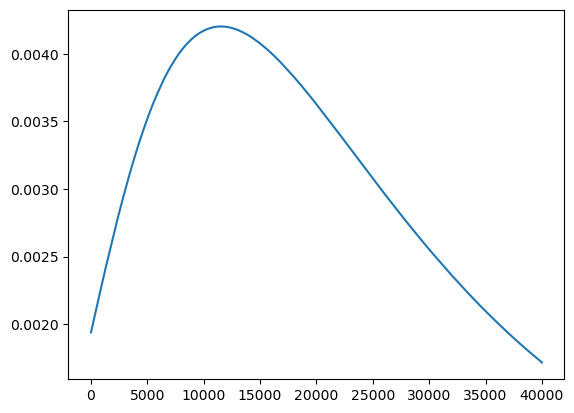

In [ ]:
plt.plot(spectra_body1[1][:, 0])

In [ ]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import GaiaG, GaiaBP, GaiaRP, Bolometric

bol = Bolometric()
gaia_g = GaiaG()
gaia_bp = GaiaBP()
gaia_rp = GaiaRP()


bol_lum = [AB_passband_luminosity(bol, vws, _spec1[:, 0]+_spec2[:, 0]) for _spec1, _spec2 in zip(spectra_body1, spectra_body2)]
gaia_g_lum = [AB_passband_luminosity(gaia_g, vws, _spec1[:, 0]+_spec2[:, 0]) for _spec1, _spec2 in zip(spectra_body1, spectra_body2)]
gaia_bp_lum = [AB_passband_luminosity(gaia_bp, vws, _spec1[:, 0]+_spec2[:, 0]) for _spec1, _spec2 in zip(spectra_body1, spectra_body2)]
gaia_rp_lum = [AB_passband_luminosity(gaia_rp, vws, _spec1[:, 0]+_spec2[:, 0]) for _spec1, _spec2 in zip(spectra_body1, spectra_body2)]

In [ ]:
bol_lum = np.array(bol_lum)
gaia_g_lum = np.array(gaia_g_lum)
gaia_bp_lum = np.array(gaia_bp_lum)
gaia_rp_lum = np.array(gaia_rp_lum)

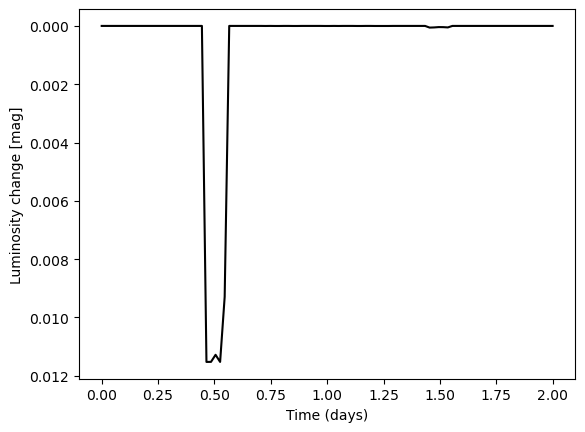

In [ ]:
plt.plot(times*365.25, bol_lum-bol_lum[0], color='black');
plt.gca().invert_yaxis();
plt.gca().set_xlabel("Time (days)");
plt.ylabel('Luminosity change [mag]');

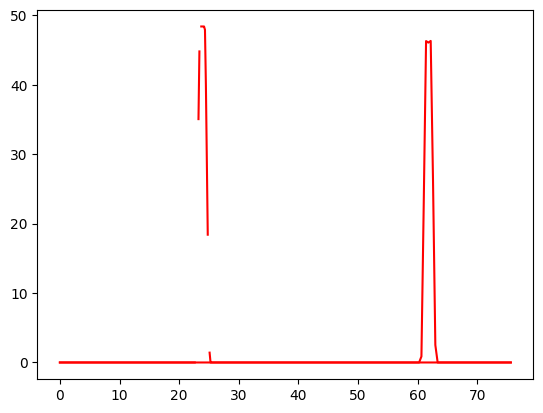

In [ ]:
plt.plot(times*365.25, [np.sum(r.occluded_areas) for r in pb1], color='red');
plt.plot(times*365.25, [np.sum(r.occluded_areas) for r in pb2], color='red');

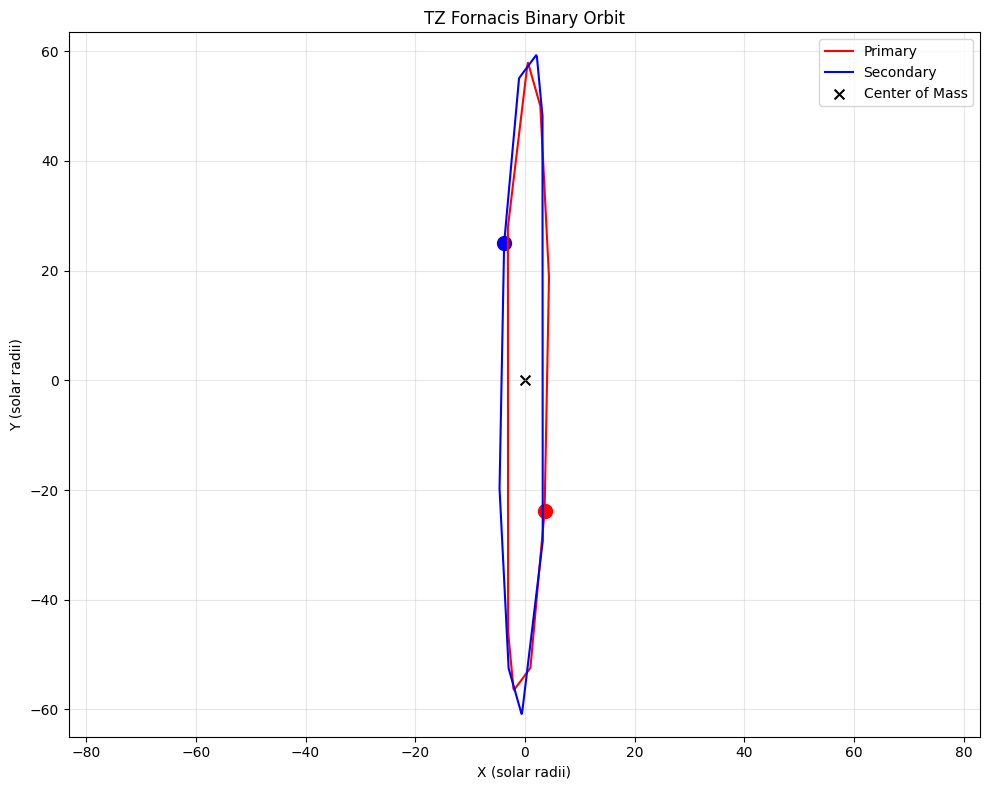

In [ ]:
# Plot the orbit of the binary system
plt.figure(figsize=(10, 8))

# Extract positions from the meshes
primary_positions = np.array([mesh.center for mesh in pb1])
secondary_positions = np.array([mesh.center for mesh in pb2])

# Plot the orbits
plt.plot(primary_positions[:, 0], primary_positions[:, 1], 'r-', label='Primary')
plt.plot(secondary_positions[:, 0], secondary_positions[:, 1], 'b-', label='Secondary')

# Mark the starting positions
plt.scatter(primary_positions[0, 0], primary_positions[0, 1], c='r', s=100, marker='o')
plt.scatter(secondary_positions[0, 0], secondary_positions[0, 1], c='b', s=100, marker='o')

# Add center of mass
plt.scatter(0, 0, c='black', s=50, marker='x', label='Center of Mass')

# Set equal aspect ratio to ensure circular orbits appear circular
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.xlabel('X (solar radii)')
plt.ylabel('Y (solar radii)')
plt.title('TZ Fornacis Binary Orbit')
plt.legend()
plt.tight_layout()


In [ ]:
import pickle
import os

# Create a dictionary with all the data we want to save
data_to_save = {
    'times': times,
    'primary_meshes': pb1,
    'secondary_meshes': pb2,
    'wavelengths': vws,
    'primary_spectra': spectra_body1,
    'secondary_spectra': spectra_body2,
    'bolometric_luminosity': bol_lum,
    'gaia_g_luminosity': gaia_g_lum,
    'gaia_bp_luminosity': gaia_bp_lum,
    'gaia_rp_luminosity': gaia_rp_lum
}

# Define the output filename
output_file = "tz_fornacis_data_correct.pkl"

# Save the data to a pickle file
with open(output_file, 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"Data saved to {os.path.abspath(output_file)}")


Data saved to /home/100/mj8805/tz_fornacis_data_correct.pkl
